In [1]:
%run ../setup_notebook.ipynb

/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "numba_utilities7.py", line 296:
@njit(signature0,parallel=True)
def erf_times_gauss_numba0(x):
^

  self.func_ir.loc))
/home/thijs/repos/dnp-code/PGM7/numba_utilities7.py:703: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float32, 1d, A), array(float32, 2d, A))
  mean_V = np.dot(weights,V)/sum_weights
/home/thijs/repos/dnp-code/PGM7/numba_utilities7.py:862: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float32, 2d, F), array(float32, 2d, A))
  dmean_v_dw = np.dot(s1.T,V)
/home/thijs/repos/dnp-code/PGM7/numba_utilities7.py:863: NumbaPerformanceWarning: np.d

Recording from /home/thijs/Desktop/20180912_Run01_spontaneous_rbm2.h5
Fraction not burst: 0.892670628489105


In [2]:
import matplotlib.patches

In [3]:
mom_names = {'means_v': '$< v_i >$', 'means_h': '$< h_\mu >$', 'pwcorr_vh': '$< v_i h_\mu >$',
             'pwcorr_vh_corr': '$< v_i h_\mu >$', 'reconstruct': 'LLH index of reconstruction',
              'pwcorr_vv': '$< v_i v_j >$', 'pwcorr_hh': r'$< h_\mu h_\nu >$', 
            'pwcorr_vv_corr': '$< v_i v_j > - < v_i> <v_j >$', 
             'pwcorr_hh_corr': r'$< h_\mu h_\nu > - < h_\mu> <h_\nu >$'}
mom_colors = {'means_v': 'blue', 'means_h': 'red', 'pwcorr_vh': 'orange',
              'pwcorr_vv': 'green', 'pwcorr_hh': 'purple', 'recon_llh': 'grey'}
for xx in ['pwcorr_vv', 'pwcorr_hh', 'pwcorr_vh']:
    mom_colors[xx + '_corr'] = mom_colors[xx]

# Tables

- Load pre-computed tables.

- Plot tables per metric

In [16]:
df_folder = '/home/thijs/repos/dnp-code/results_df_lookup/'
df_names = ['df_lookup__burstsFalse_testtest_correctpwvvTrue_2020-03-02__20180912-Run01.h5']
# df_names = ['df_lookup__burstsTrue_testtest_correctpwvvTrue_2020-02-11__20180912-Run01.h5']
# df_names = ['df_lookup__burstsTrue_testtest_correctpwvvFalse_2020-02-22__20180912-Run01.h5',
#             'df_lookup__burstsTrue_testtest_correctpwvvFalse_2020-02-15__20180912-Run01.h5']
# df_names = ['df_lookup__burstsFalse_testtest_correctpwvvFalse_2020-02-24__20180912-Run01.h5',
#             'df_lookup__burstsFalse_testtest_correctpwvvFalse_0_2020-02-24__20180912-Run01.h5']

In [17]:
# df_lookup_dict = {ii: pd.read_hdf(x) for ii, x in enumerate(df_names)}
# df_lookup_2 = pd.read_hdf('/home/thijs/repos/dnp-code/results_df_lookup/df_lookup__burstsTrue_testtest_2020-02-22__20180912-Run01.h5')
# assert (df_lookup_1.columns == df_lookup_2.columns).all()

df_lookup = pd.concat([pd.read_hdf(df_folder + x) for x in df_names])
df_lookup = df_lookup[df_lookup.l1 != 0.001]

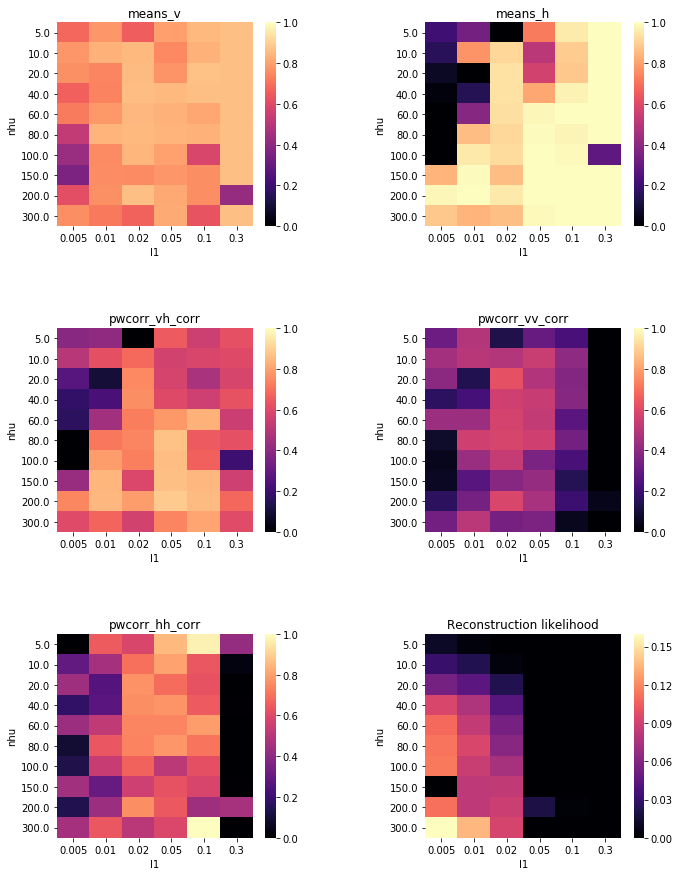

In [18]:
plt.rcParams['figure.figsize'] = (11, 15)
plt.subplots_adjust(hspace=0.5, wspace=0.5)

list_comp_moms = ['means_v', 'means_h', 'pwcorr_vh_corr', 'pwcorr_vv_corr', 'pwcorr_hh_corr']

ax_hm = {}
for iplot, stat in enumerate(list_comp_moms):
    plt.subplot(3, 2, iplot+1)
    ax_hm[iplot] = sns.heatmap(pd.pivot_table(df_lookup, values=stat, 
                               index='nhu', columns='l1'), 
                vmin=0, vmax=1, 
                cmap='magma')
    b, t = ax_hm[iplot].get_ylim() # correct for default cut off
    b += 0.5 # see https://github.com/mwaskom/seaborn/issues/1773
    t -= 0.5 # 
    plt.ylim(b, t) # u
    plt.title(stat)

plt.subplot(3, 2, 6)
llh_table = pd.pivot_table(df_lookup, values='reconstruct_med', 
                           index='nhu', columns='l1')
ax_hm['llh'] = sns.heatmap(llh_table, #vmin=np.nanmin(llh_table[llh_table != 0]), 
            vmax=np.nanmax(llh_table[llh_table != 0]),
            vmin=0, cmap='magma');
b, t = ax_hm['llh'].get_ylim() # correct for default cut off
b += 0.5 # see https://github.com/mwaskom/seaborn/issues/1773
t -= 0.5 # 
plt.ylim(b, t) # u
plt.title('Reconstruction likelihood');

In [32]:
stat_mat = {}
for iplot, stat in enumerate(list_comp_moms + ['reconstruct_med']):
    stat_mat[stat] = pd.pivot_table(df_lookup, values=stat, index='nhu', columns='l1')
min_proj = stat_mat[list_comp_moms[0]]
for stat in list_comp_moms[1:]:
    min_proj = min_proj.combine(stat_mat[stat], np.minimum)
    
norm_llh_table = llh_table #(llh_table[llh_table != 0] - np.nanmin(llh_table[llh_table != 0]))
norm_llh_table = norm_llh_table / np.nanmax(norm_llh_table)
min_proj = min_proj.combine(norm_llh_table, np.minimum)

Text(0.5, 1, 'Elementwise minimum of all 6 conditions')

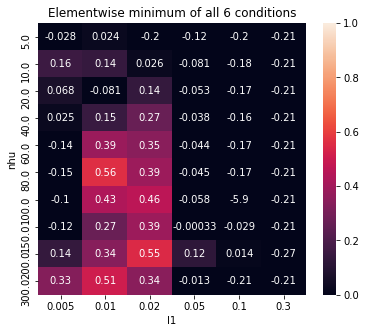

In [33]:
plt.rcParams['figure.figsize'] = (6, 5)
summ_hm = sns.heatmap(min_proj, vmin=0, vmax=1, annot=True)
b, t = summ_hm.get_ylim() # correct for default cut off
b += 0.5 # see https://github.com/mwaskom/seaborn/issues/1773
t -= 0.5 # 
plt.ylim(b, t) # update the ylim(bottom, top) values
# summ_hm.set_yticklabels(rotation=90)
plt.title('Elementwise minimum of all 6 conditions')

# Load binned stats

In [34]:
binned_stats_dict = {}
for fn in df_names:

    binned_stats_name = (df_folder + 'binned_stats_dict__' + 
                         fn.lstrip('df_lookup').rstrip('h5') + 'pkl')

    binned_stats_dict = {**binned_stats_dict, **pickle.load(open(binned_stats_name, 'rb'))}

## Info
# The value of a dict entry binned_stats_dict[ts_rbm][mom] 
# is (plot_bins, mean_g_bins, std_g_bins)

# PLOT full fig

In [112]:
arg_nhu, arg_l1 = np.where(min_proj == min_proj.max().max())
arg_nhu, arg_l1 = arg_nhu[0], arg_l1[0]
max_nhu = min_proj.iloc[arg_nhu, :].name
max_l1 = min_proj.iloc[:, arg_l1].name


arg_nhu_shown = arg_nhu
arg_l1_shown = arg_l1
nhu_shown = 200 #max_nhu
l1_shown =  0.02 #max_l1


In [116]:
std_se = 'std'
save_fig = True
current_datetime = str(datetime.datetime.now())[:10] + '_' + str(datetime.datetime.now())[11:13] + '-' + str(datetime.datetime.now())[14:16]
save_folder = '/home/thijs/repos/zf-rbm/Figures/pdfs/'
name_fig = (f'fig_model-selection_' + f'{df_names[0].split("_")[3]}_{df_names[0].split("_")[4]}_{df_names[0].split("_")[5]}_' + 
           f'{current_datetime}.pdf') 

In [117]:
ts_rbm = df_lookup[np.logical_and(df_lookup.l1 == l1_shown, df_lookup.nhu == nhu_shown)].timestamp.values[0]
print(ts_rbm)

2020-02-22-0009


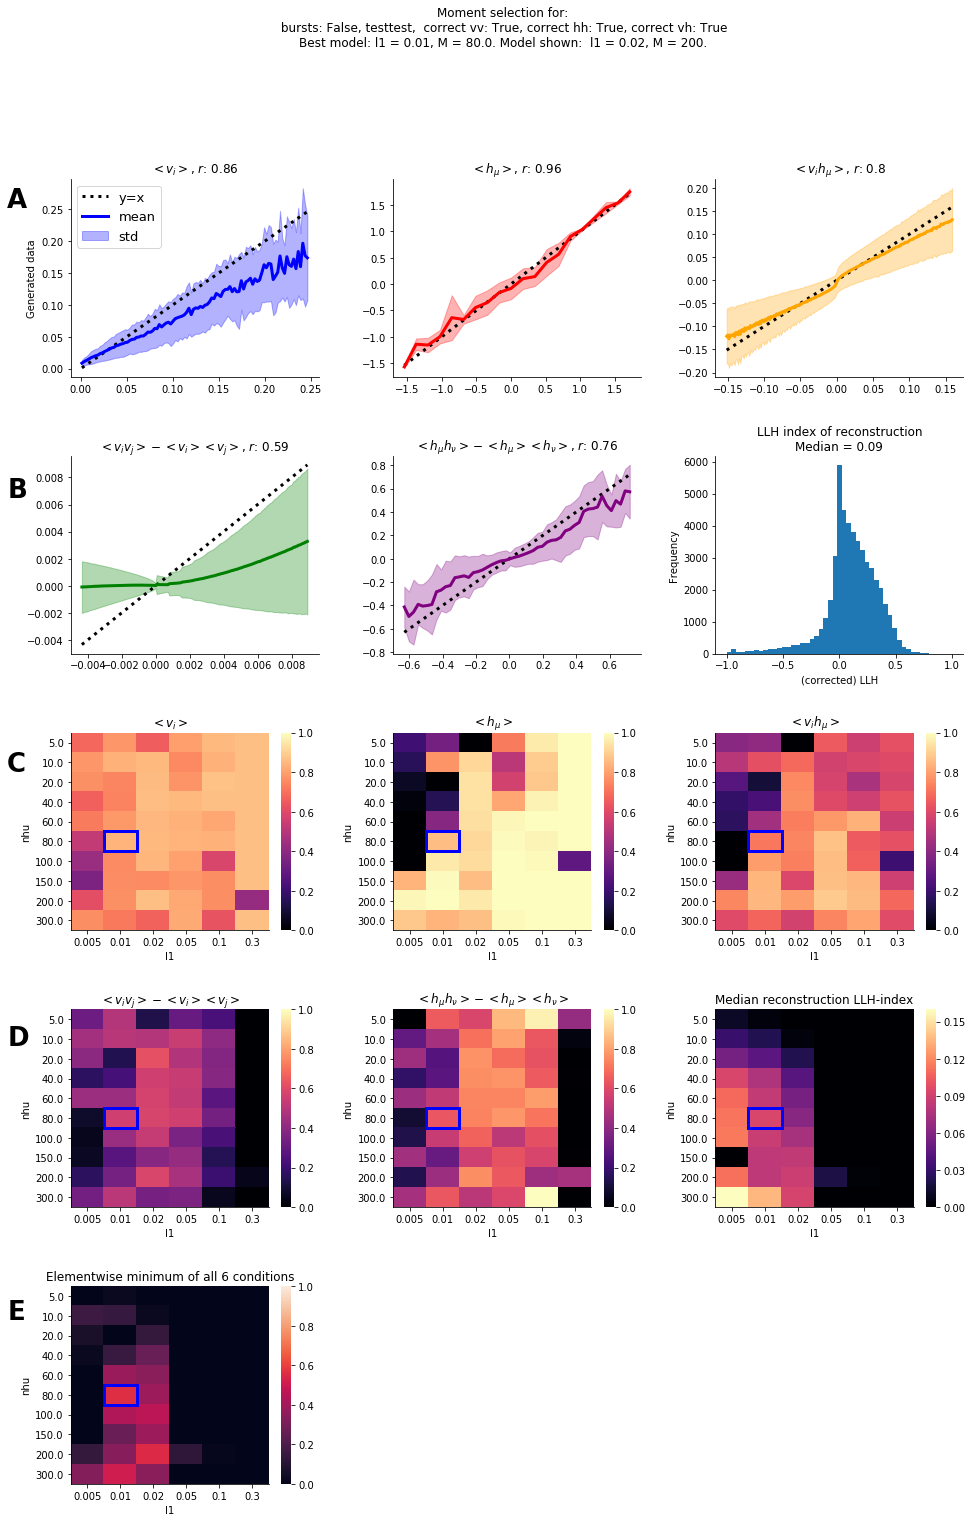

In [118]:
plt.rcParams['figure.figsize'] = (16, 24)
plt.subplots_adjust(wspace=0.3, hspace=0.4)

assert ts_rbm in binned_stats_dict.keys()
indiv_ax = {}
sum_ax = {}
for i_plot, comp_moment in enumerate(list_comp_moms):
    indiv_ax[comp_moment] = plt.subplot(5, 3, int(i_plot + 1))
    plot_bins = binned_stats_dict[ts_rbm][comp_moment][0]
    mean_bins = binned_stats_dict[ts_rbm][comp_moment][1]
    std_bins = binned_stats_dict[ts_rbm][comp_moment][2]
    inds_nn = ~np.isnan(mean_bins)
    plot_bins, mean_bins, std_bins = plot_bins[inds_nn], mean_bins[inds_nn], std_bins[inds_nn]
    ro = df_lookup[df_lookup.timestamp == ts_rbm][comp_moment].values[0]
    
    indiv_ax[comp_moment].plot([plot_bins.min(), plot_bins.max()], [plot_bins.min(), plot_bins.max()], ':', color='k', label='y=x')
    indiv_ax[comp_moment].plot(plot_bins, mean_bins, color=mom_colors[comp_moment], label='mean')
    indiv_ax[comp_moment].fill_between(plot_bins, mean_bins, mean_bins+std_bins, color=mom_colors[comp_moment], alpha=0.3, label=std_se)
    indiv_ax[comp_moment].fill_between(plot_bins, mean_bins, mean_bins-std_bins, color=mom_colors[comp_moment], alpha=0.3)
    
    sum_ax[comp_moment] = plt.subplot(5, 3, int(i_plot + 7))
    sum_ax[comp_moment] = sns.heatmap(pd.pivot_table(df_lookup, values=comp_moment, 
                               index='nhu', columns='l1'), 
                vmin=0, vmax=1, 
                cmap='magma')
    b, t = sum_ax[comp_moment].get_ylim() # correct for default cut off
    b += 0.5 # see https://github.com/mwaskom/seaborn/issues/1773
    t -= 0.5 # 
    sum_ax[comp_moment].set_ylim(b, t) # u
    sum_ax[comp_moment].set_title(r'{}'.format(mom_names[comp_moment]))
    sum_ax[comp_moment].add_patch(matplotlib.patches.Rectangle((arg_l1_shown, arg_nhu_shown), 1, 1, 
                                                               fill=False, edgecolor='blue', lw=3))
    if i_plot == 0:
        indiv_ax[comp_moment].set_ylabel('Generated data');
        yscale = indiv_ax[comp_moment].get_ylim()[1] * 0.85
        indiv_ax[comp_moment].text(s='A', x=-0.08, y=yscale, fontdict={'size': 26, 'weight':'bold'})
        indiv_ax[comp_moment].text(s='B', x=-0.08, y=-0.8 * yscale, fontdict={'size': 26, 'weight':'bold'})
        indiv_ax[comp_moment].text(s='C', x=-0.08, y=-2.5 * yscale, fontdict={'size': 26, 'weight':'bold'})
        indiv_ax[comp_moment].text(s='D', x=-0.08, y=-4.2 * yscale, fontdict={'size': 26, 'weight':'bold'})
        indiv_ax[comp_moment].text(s='E', x=-0.08, y=-5.9 * yscale, fontdict={'size': 26, 'weight':'bold'})
        indiv_ax[comp_moment].legend(prop={'size':13}, loc='upper left')

    indiv_ax[comp_moment].set_title(r'{}, $r$: '.format(mom_names[comp_moment]) +f'{str(np.round(ro, 2))}');

indiv_ax['reconstruct'] = plt.subplot(5, 3, 6)
plt.hist(binned_stats_dict[ts_rbm]['reconstruct'], bins=np.linspace(-1, 1, 50))
indiv_ax['reconstruct'].set_title(mom_names['reconstruct'] + f'\nMedian = {np.round(df_lookup[df_lookup.timestamp == ts_rbm]["reconstruct_med"].values[0], 2)}')
indiv_ax['reconstruct'].set_xlabel('(corrected) LLH'); indiv_ax['reconstruct'].set_ylabel('Frequency')
    
sum_ax['llh'] = plt.subplot(5, 3, 12)
llh_table = pd.pivot_table(df_lookup, values='reconstruct_med', 
                           index='nhu', columns='l1')
sum_ax['llh'] = sns.heatmap(llh_table, #vmin=np.nanmin(llh_table[llh_table != 0]), 
            vmax=np.nanmax(llh_table[llh_table != 0]),
            vmin=0, cmap='magma');
b, t = sum_ax['llh'].get_ylim() # correct for default cut off
b += 0.5 # see https://github.com/mwaskom/seaborn/issues/1773
t -= 0.5 # 
sum_ax['llh'].set_ylim(b, t) # u
sum_ax['llh'].set_title('Median reconstruction LLH-index');
sum_ax['llh'].add_patch(matplotlib.patches.Rectangle((arg_l1, arg_nhu), 1, 1, 
                                                               fill=False, edgecolor='blue', lw=3))

sum_ax['aggr'] = plt.subplot(5, 3, 13)
sum_ax['aggr'] = sns.heatmap(min_proj, vmin=0, vmax=1, annot=False)
b, t = sum_ax['aggr'].get_ylim() # correct for default cut off
b += 0.5 # see https://github.com/mwaskom/seaborn/issues/1773
t -= 0.5 # 
sum_ax['aggr'].set_ylim(b, t) # update the ylim(bottom, top) values
# summ_hm.set_yticklabels(rotation=90)
sum_ax['aggr'].set_title('Elementwise minimum of all 6 conditions')
sum_ax['aggr'].add_patch(matplotlib.patches.Rectangle((arg_l1_shown, arg_nhu_shown), 1, 1, 
                                                               fill=False, edgecolor='blue', lw=3))
    
if 'settings' in binned_stats_dict.keys():
    opt_str_settings = f'bursts: {binned_stats_dict["settings"]["use_bursts"]}, {binned_stats_dict["settings"]["descr_traintest"]},  correct vv: {binned_stats_dict["settings"]["correct_vv_pwcorr"]}, correct hh: {binned_stats_dict["settings"]["correct_hh_pwcorr"]}, correct vh: {binned_stats_dict["settings"]["correct_vh_pwcorr"]}'
else:
    opt_str_settings = f'{df_names[0].split("_")[3]}, {df_names[0].split("_")[4]}, {df_names[0].split("_")[5]}'
plt.suptitle(f'Moment selection for:' +
            '\n ' + opt_str_settings + 
            f'\nBest model: l1 = {max_l1}, M = {max_nhu}. Model shown:  l1 = {l1_shown}, M = {nhu_shown}.')
sns.despine()
if save_fig:
    plt.savefig(save_folder + name_fig)